In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# 1. Logistic regression

## Input:

1. $N$ (Number of data points)
2. $mx_{1}, vx_{1}, my_{1}, vy_{1}, mx_{2}, vx_{2}, my_{2}, vy_{2}$ ($m$:mean, $v$ variance)

In [2]:
def switch_case(mode):
    if mode == 'case 1':      
        # Case 1
        N = 50
        mx1=my1 = 1
        mx2=my2 = 10
        vx1=vy1=vx2=vy2 = 2
    if mode == 'case 2':
        # case 2
        N = 50
        mx1=my1=1
        mx2=my2=3
        vx1=vy1=2
        vx2=vy2=4
    return mx1, my1, mx2, my2, vx1, vy1, vx2, vy2, N

In [3]:
mx1, my1, mx2, my2, vx1, vy1, vx2, vy2, N = switch_case('case 2')

## Function:

1. Generate $n$ data point $D1 = (x_{1}, y_{1}), (x_{2}, y_{2}), ..., (x_{n}, y_{n})$, where $x$ and $y$ are independently samples from $N(mx_{1}, vx_{1})$ and $N(my_{1}, vy_{1})$ respectively.
2. Generate $n$ data point $D2 = (x_{1}, y_{1}), (x_{2}, y_{2}), ..., (x_{n}, y_{n})$, where $x$ and $y$ are independently samples from $N(mx_{2}, vx_{2})$ and $N(my_{2}, vy_{2})$ respectively.
3. Use Logistic regression to  separate $D1$ and $D2$. 

In [4]:
def univariate_gaussian_data_generator(m, s):    
    # Box-Muller method
    U = np.random.uniform(0,1)
    V = np.random.uniform(0,1)
    Z = np.sqrt(-2*np.log(U))*math.cos(2*math.pi*V)
    
    data = m + s**0.5*Z # output
    
    return data

In [5]:
D1 = []
D2 = []
def to_X(D1, D2):
    X = np.ones((2 * len(D1), 3))
    X[:, 1:] = np.vstack((D1,D2))
    return X

def to_y(N):
    y = np.zeros((2 * N, 1))
    y[N:] = np.ones((N, 1))
    return y

for i in range(N):
    D1.append(((univariate_gaussian_data_generator(mx1, vx1)), univariate_gaussian_data_generator(my1, vy1)))
    D2.append(((univariate_gaussian_data_generator(mx2, vx2)), univariate_gaussian_data_generator(my2, vy2)))

X = to_X(D1,D2)
y = to_y(N)

## Gradient descent

$W_{j+1} = W_{j} - \lambda X^{T}(f(W^{T}x)-Y)$

In [6]:
def gradient_descent(X, y, lr=0.001):
    w = np.random.rand(3,1)
    count=0
    while(True):
        count += 1
        w_old = w
        D = X.T.dot( y -(1/(1+np.exp(-X.dot(w)))) )
        w = w + D
        if(np.linalg.norm(w-w_old)<1e-2 or (count>1e4 and np.linalg.norm(w-w_old)<80) or count>1e5):
                break
    
    print('w:')
    print(w[0])
    print(w[1])
    print(w[2])
    
    return w

def predict(X, w):
    N = len(X)
    predict = np.empty((N,1))
    for i in range(N):
        predict[i]=0 if X[i]@w<0 else 1
    return predict

def show_confusion_matrix(y, pred):
    TP=TN=FP=FN=0
    
    for i in range(len(pred)):
        if y[i] == 0:
            if y[i] == pred[i]:
                TN+=1
            else:
                FP+=1
        if y[i] == 1:
            if y[i] == pred[i]:
                TP+=1
            else:
                FN+=1
    matrix=np.empty((2,2))
    matrix[0,0],matrix[0,1],matrix[1,0],matrix[1,1]=TP,FN,FP,TN
    print('Confusion Matrix:')
    print('               Predict cluster 1  Predict cluster 2')
    print('Is cluster 1        {:.0f}               {:.0f}       '.format(matrix[0,0],matrix[0,1]))
    print('Is cluster 2        {:.0f}               {:.0f}       '.format(matrix[1,0],matrix[1,1]))
    print()
    print('Sensitivity (Successfully predict cluster 1): {}'.format(matrix[0,0]/(matrix[0,0]+matrix[1,0])))
    print('Specificity (Successfully predict cluster 2): {}'.format(matrix[0,0]/(matrix[0,0]+matrix[0,1])))

In [7]:
w_g = gradient_descent(X, y)
pred_g = predict(X, w_g)
show_confusion_matrix(y, pred_g)

w:
[-132.44159455]
[39.85027402]
[50.93329921]
Confusion Matrix:
               Predict cluster 1  Predict cluster 2
Is cluster 1        43               7       
Is cluster 2        11               39       

Sensitivity (Successfully predict cluster 1): 0.7962962962962963
Specificity (Successfully predict cluster 2): 0.86


## Newton's in logistic regression

$W_{n+1} = W_{n} - (X^{T}RX)^{-1}X^{T}(f(W^{T}_{n}x)-Y) $ <br>
where R is diagonal matrix mxm of$\frac{e^{-W^{T}_{n}x_{i}}}{(1+e^{-W^{T}x_{i}})^{2}}$

In [8]:
def newton_method(X, y, lr=0.001):
    eps=1e-2
    W = np.random.rand(3,1)
    m = len(X)
    R = np.zeros((m,m))
    for i in range(m):
        #R[i,i] = np.exp(-W.T@X[i])/(1+np.exp(-W.T@X[i]))**2
        R[i,i]=np.exp(-X[i]@W)/np.power(1+np.exp(-X[i]@W),2)
    H = X.T@R@X
    
    try:
        H_inv = np.linalg.inv(H)
    except np.linalg.LinAlgError as error:
        print(str(error))
        print('Hessian matrix non invertible, switch to Gradient descent')
    
    gradient = 100
    while np.sqrt(np.sum(gradient**2))>eps: 
        gradient = H_inv@X.T@(y-1/(1+np.exp(-X@W)))
        W = W + lr*gradient
    
    print('w:')
    print(W[0])
    print(W[1])
    print(W[2])
    return W


In [9]:
w = newton_method(X, y)
pred_newtons = predict(X, w)
show_confusion_matrix(y, pred_newtons)

w:
[-3.1382794]
[0.69909539]
[1.02461887]
Confusion Matrix:
               Predict cluster 1  Predict cluster 2
Is cluster 1        39               11       
Is cluster 2        7               43       

Sensitivity (Successfully predict cluster 1): 0.8478260869565217
Specificity (Successfully predict cluster 2): 0.78


In [10]:
def plot_ground_truth(D1, D2):
    D1 = np.array(D1)
    D2 = np.array(D2)
    plt.figure()
    plt.plot(D1[:,0], D1[:,1],'ro')
    plt.plot(D2[:,0], D2[:,1],'bo')
    plt.title('Ground Truth')
    plt.show()

def plt_newtons_result(D1, D2, pred):
    C0 = []
    C1 = []
    D1 = np.array(D1)
    D2 = np.array(D2)
    src_data = np.vstack((D1,D2))
    for i in range(len(pred)):
        if pred[i] == 0:
            C0.append(src_data[i]) 
        else:
            C1.append(src_data[i])
    
    C0 = np.array(C0)
    C1 = np.array(C1)
    plt.figure()
    plt.plot(C0[:,0], C0[:,1],'ro')
    plt.plot(C1[:,0], C1[:,1],'bo')
    plt.title('Newtons method')
    plt.show()
    
def plt_gradient_descent_result(D1, D2, pred):
    C0 = []
    C1 = []
    D1 = np.array(D1)
    D2 = np.array(D2)
    src_data = np.vstack((D1,D2))
    for i in range(len(pred)):
        if pred[i] == 0:
            C0.append(src_data[i]) 
        else:
            C1.append(src_data[i])
    
    C0 = np.array(C0)
    C1 = np.array(C1)
    plt.figure()
    plt.plot(C0[:,0], C0[:,1],'ro')
    plt.plot(C1[:,0], C1[:,1],'bo')
    plt.title('Gradient Descent')
    plt.show()

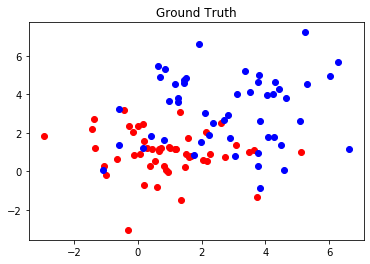

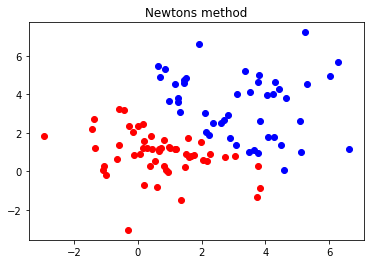

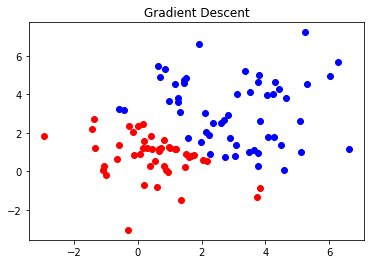

In [11]:
plot_ground_truth(D1, D2)
plt_newtons_result(D1, D2, pred_newtons)
plt_gradient_descent_result(D1, D2, pred_g)